In [151]:
import os
import sys
import time
import json
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import CubicSpline
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [152]:
with open('device.json','r') as fid:
    ARC_geom = json.load(fid)

In [153]:
print(ARC_geom.keys())
for segment in ARC_geom['wall']['description_2d']:
    print(segment['type'])
    # if 'limiter' in segment:
    #     for unit in segment['limiter']['unit']:
    #         print(unit['outline'])
    # elif 'vessel' in segment:
    #     for unit in segment['vessel']['unit']:
    #         if 'annular' in unit:
    #             print(unit['annular']['resistivity'])

dict_keys(['dataset_description', 'pf_active', 'summary', 'wall'])
{'description': 'Single limiter surface', 'index': 0}
{'description': 'Annular description of vessel', 'index': 2}
{'description': 'Annular description of blanket', 'index': 5}
{'description': 'Block description of shield', 'index': 6}


In [154]:
limiter_obj = ARC_geom['wall']['description_2d'][0]['limiter']['unit'][0]['outline']
limiter = np.vstack((limiter_obj['r'],limiter_obj['z']))
#
vv_tungsten_obj = ARC_geom['wall']['description_2d'][1]['vessel']['unit'][0]['annular']
vv_tungsten = np.vstack((vv_tungsten_obj['outline_inner']['r'],vv_tungsten_obj['outline_inner']['z']))
vv_tungsten_outer = np.vstack((vv_tungsten_obj['outline_outer']['r'],vv_tungsten_obj['outline_outer']['z']))
tungsten_thickness = (vv_tungsten[:,0]-vv_tungsten_outer[:,0])[0]
print("W thickness = {0:.4} [cm]".format(tungsten_thickness*100.0))
#
vv_inner_obj = ARC_geom['wall']['description_2d'][1]['vessel']['unit'][1]['annular']
vv_inner = np.vstack((vv_inner_obj['outline_inner']['r'],vv_inner_obj['outline_inner']['z']))
vv_inner_outer = np.vstack((vv_inner_obj['outline_outer']['r'],vv_inner_obj['outline_outer']['z']))
vv_inner_thickness = (vv_inner[:,0]-vv_inner_outer[:,0])[0]
print("Inner VV thickness = {0:.4} [cm]".format(vv_inner_thickness*100.0))
#
vv_outer_obj = ARC_geom['wall']['description_2d'][1]['vessel']['unit'][2]['annular']
vv_outer = np.vstack((vv_outer_obj['outline_outer']['r'],vv_outer_obj['outline_outer']['z']))
vv_outer_inner = np.vstack((vv_outer_obj['outline_inner']['r'],vv_outer_obj['outline_inner']['z']))
vv_outer_thickness = (vv_outer_inner[:,0]-vv_outer[:,0])[0]
print("Outer VV thickness = {0:.4} [cm]".format(vv_outer_thickness*100.0))
#
blanket_obj = ARC_geom['wall']['description_2d'][2]['vessel']['unit'][0]['annular']['outline_outer']
blanket = np.vstack((blanket_obj['r'],blanket_obj['z']))

W thickness = 0.5 [cm]
Inner VV thickness = 1.0 [cm]
Outer VV thickness = 3.0 [cm]


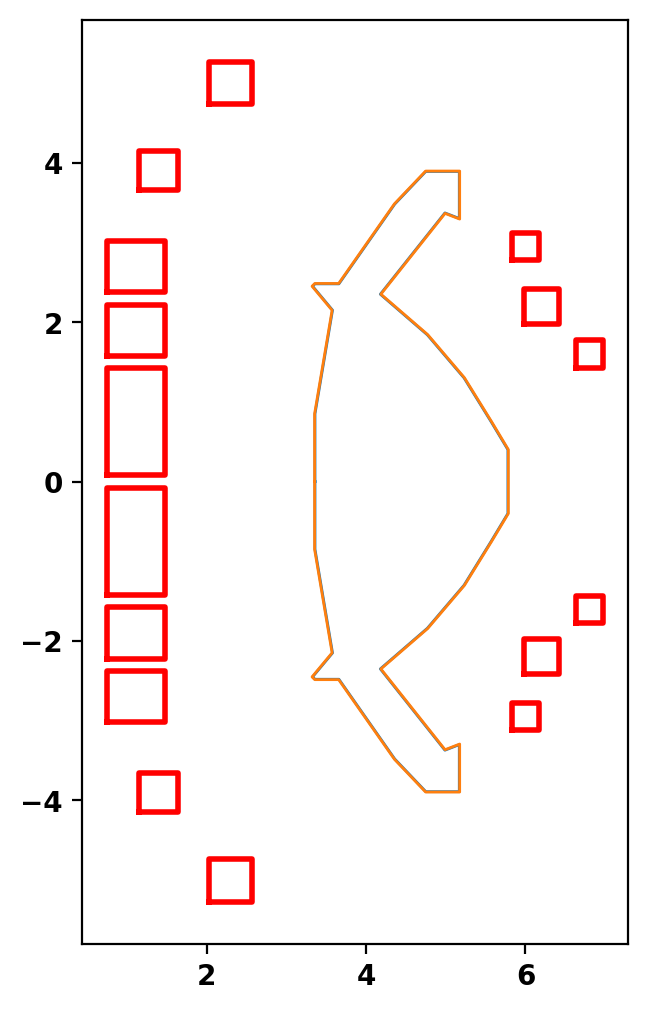

In [155]:
fig, ax = plt.subplots(1,1)
# ax.plot(limiter[0,:],limiter[1,:])
ax.plot(vv_tungsten[0,:],vv_tungsten[1,:], lw = 1)
ax.plot(vv_inner[0,:],vv_inner[1,:], lw = 1)
#ax.plot(vv_outer[0,:],vv_outer[1,:])
#ax.plot(blanket[0,:],blanket[1,:])
coil_extents = []
coil_sets = []
for coil in ARC_geom['pf_active']['coil']:
    extent_tmp = [1.E10,-1.E10,1.E10,-1.E10]
    coil_tmp = []
    for filament in coil['element']:
        fil_rad = filament['geometry']['annulus']['radius_outer']
        extent_tmp[0] = min(extent_tmp[0],filament['geometry']['annulus']['r']+fil_rad)
        extent_tmp[1] = max(extent_tmp[1],filament['geometry']['annulus']['r']-fil_rad)
        extent_tmp[2] = min(extent_tmp[2],filament['geometry']['annulus']['z']+fil_rad)
        extent_tmp[3] = max(extent_tmp[3],filament['geometry']['annulus']['z']-fil_rad)
        coil_tmp.append([filament['geometry']['annulus']['r'],filament['geometry']['annulus']['z']])
        # ax.plot(filament['geometry']['annulus']['r'],filament['geometry']['annulus']['z'],'r.')
    ax.plot([extent_tmp[0], extent_tmp[1], extent_tmp[1], extent_tmp[0], extent_tmp[0]],[extent_tmp[2], extent_tmp[2], extent_tmp[3], extent_tmp[3], extent_tmp[2]],'r')
    coil_extents.append(extent_tmp)
    coil_sets.append({'name': coil['name'], 'filaments': coil_tmp})
coil_sets.append({'name': 'plasma', 'filaments': [[4.0, 0.0]]})
ax.set_aspect('equal','box')


In [119]:
device_version = 'V2E'
np.savetxt('ARC_{0}-tungsten_vv.dat'.format(device_version),vv_tungsten.transpose())
np.savetxt('ARC_{0}-inner_vv.dat'.format(device_version),vv_inner.transpose())
np.savetxt('ARC_{0}-outer_vv.dat'.format(device_version),vv_outer.transpose())

In [150]:
np.savetxt('ARC_{0}-inner_vv_mod.dat'.format(device_version),new_vv_inner)

In [156]:
oft_element=ET.Element("oft")
xml_doc=ET.ElementTree(oft_element)
thincurr_element = ET.SubElement(oft_element,"thincurr")
eta_element = ET.SubElement(thincurr_element,"eta")
eta_element.text = '{0:.4E} {1:.4E}'.format(3.E-7/tungsten_thickness, 6.E-7/vv_inner_thickness, 6.E-7/vv_outer_thickness) # Separate tungsten layer
# eta_element.text = '{0:.4E} {1:.4E}'.format(6.E-7/(tungsten_thickness+vv_inner_thickness), 6.E-7/vv_outer_thickness) # Single inner wall
for coil in coil_sets:
    coil_set = ET.SubElement(thincurr_element,"coil_set")
    coil_set.set("name",coil['name'])
    for filament in coil['filaments']:
        filament_element = ET.SubElement(coil_set,"coil_set")
        filament_element.text = '{0:.4E} {1:.4E}'.format(*filament)
ET.indent(xml_doc, space="  ", level=0)
xml_doc.write("ARC_{0}-ThinCurr.xml".format(device_version))

In [157]:
vv_inner = vv_inner.transpose()
vv_inner = vv_inner[:-1,:]

In [179]:
np.shape(new_pts)

(4, 2)

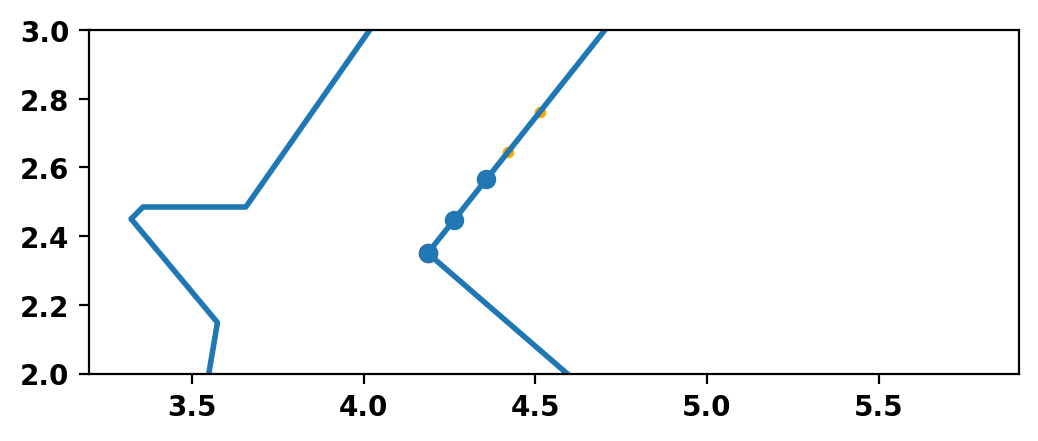

In [184]:
ind = 21
dist = 0.2
width = 0.15
theta_gap = 0.1

dir = (vv_inner[ind+1,:]-vv_inner[ind,:])/np.linalg.norm(vv_inner[ind+1,:]-vv_inner[ind,:])
center = vv_inner[ind,:] + dist*dir
new_pts = np.array([center-dir*width/2, center+dir*width/2, center+dir*(width/2+theta_gap), center+dir*(3*width/2 + theta_gap)])
plt.plot(vv_inner[:,0], vv_inner[:,1])
plt.gca().set_aspect(aspect = 1)
plt.scatter(vv_inner[ind,0], vv_inner[ind,1], color = 'r')
plt.scatter(new_pts[:,0], new_pts[:,1], s = 10, color = 'orange')
plt.ylim([2,3])
vv_inner_new = np.insert(vv_inner, ind+1, new_pts, axis = 0)
plt.scatter(vv_inner_new[:24,0], vv_inner_new[:24,1])

In [132]:
def distance(p1, p2):
    return np.linalg.norm(np.array(p2) - np.array(p1))

def equal_distance_polygon(vertices, n_points):
    # Step 1: Compute the perimeter of the polygon
    perimeter = 0
    for i in range(len(vertices)):
        perimeter += distance(vertices[i], vertices[(i + 1) % len(vertices)])
    # Step 2: Compute the desired spacing between points
    spacing = perimeter / n_points
    
    # Step 3: Generate the new vertices with equal distance
    new_vertices = []
    current_vertex = vertices[0]
    new_vertices.append(current_vertex)
    spacing_mod = spacing
    for i in range(1, len(vertices) + 1):
        accumulated_distance = 0
        current_vertex = vertices[(i-1) % len(vertices)]
        next_vertex = vertices[i % len(vertices)]
        segment_distance = distance(current_vertex, next_vertex)
        current_point = current_vertex
        while accumulated_distance + spacing_mod < segment_distance:
            direction = (np.array(next_vertex) - np.array(current_vertex))/segment_distance
            new_point = current_point + spacing_mod*direction
            new_vertices.append(new_point)
            accumulated_distance +=spacing_mod
            current_point = new_point
            spacing_mod = spacing
        spacing_mod = spacing-(segment_distance-accumulated_distance)
    
    return np.array(new_vertices)
        
        
            

In [123]:
#20.317884287864143
#0.20317884287864144
#perimeter and spacing for 100 point case

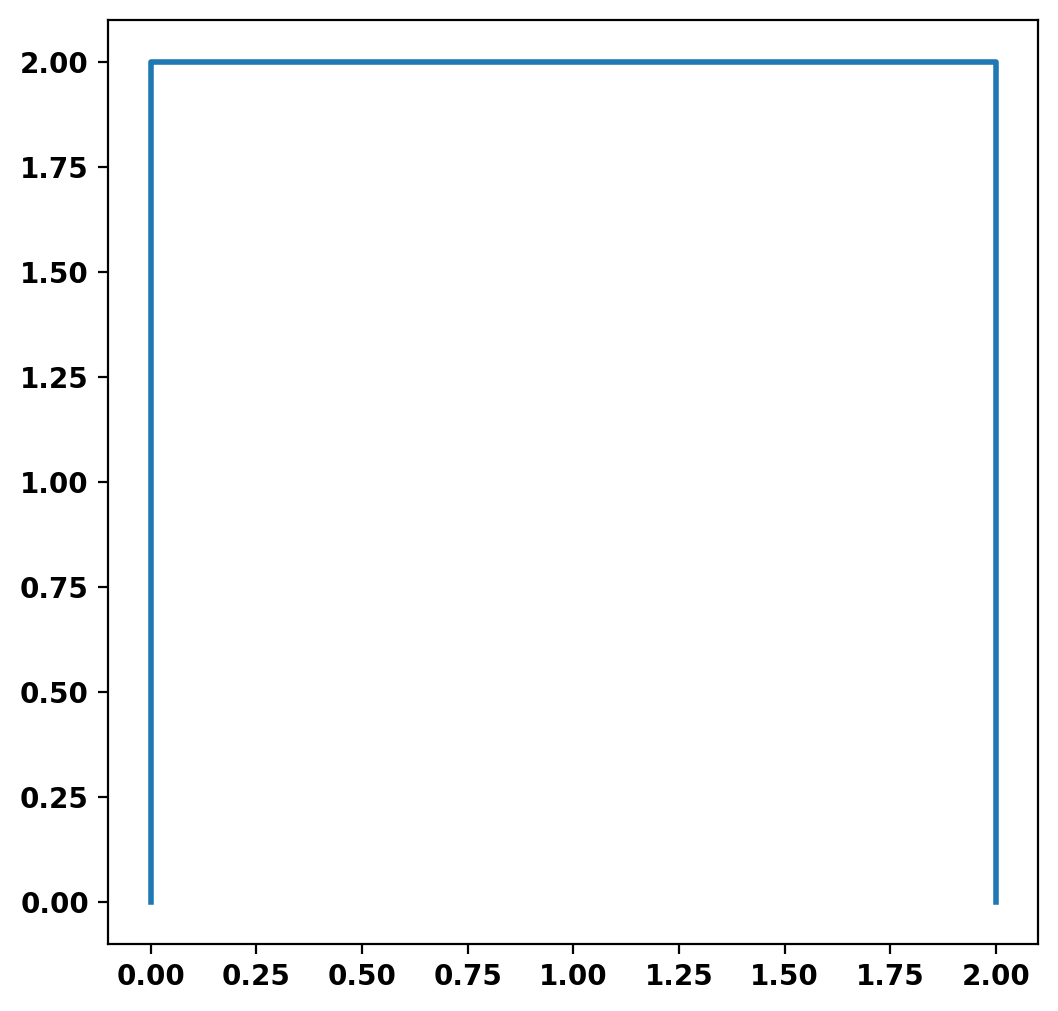

In [133]:
square = np.array([[0, 0], [0,2], [2,2], [2,0]])
plt.plot(square[:,0], square[:,1])

In [149]:
new_vv_inner = equal_distance_polygon(vv_inner, n_points = 180)